## To analyse synthesis and uncertainty

### Set parameters

In [1]:
RUN_ID = 32 # set this to prevent overlapped saving of model and data
INPUT_MODALITY = "T1_T2_FLAIR"
RANDOM_SEED = 0
ROOT_DIR = "/scratch1/sachinsa/cont_syn"
QR_REGRESSION = True

In [2]:
import os
import matplotlib.pyplot as plt

import pdb
import numpy as np
import pickle
from utils.logger import Logger

logger = Logger(log_level='DEBUG')

[INFO] Logging level is: DEBUG


In [3]:
load_dir = os.path.join(ROOT_DIR, f"run_{RUN_ID}")
fig_save_dir_root = os.path.join("..", "figs")
fig_save_dir = os.path.join(fig_save_dir_root, "runs", f"run_{RUN_ID}")
os.makedirs(fig_save_dir, exist_ok=True)

In [4]:
with open(os.path.join(load_dir, 'training_info.pkl'), 'rb') as f:
    training_info = pickle.load(f)
    epoch_loss_values = training_info['epoch_loss_values']
    metric_values = training_info['metric_values']

logger.info("PARAMETERS\n-----------------")
logger.info(f"RUN_ID: {RUN_ID}")
logger.info(f"QR_REGRESSION: {QR_REGRESSION}")
logger.info(f"ROOT_DIR: {ROOT_DIR}")
print("")

[INFO] PARAMETERS
-----------------
[INFO] RUN_ID: 32
[INFO] QR_REGRESSION: True
[INFO] ROOT_DIR: /scratch1/sachinsa/cont_syn



In [5]:
max_epochs = len(epoch_loss_values)
val_interval = len(epoch_loss_values)//len(metric_values)
print("Max epochs:", max_epochs)

Max epochs: 660


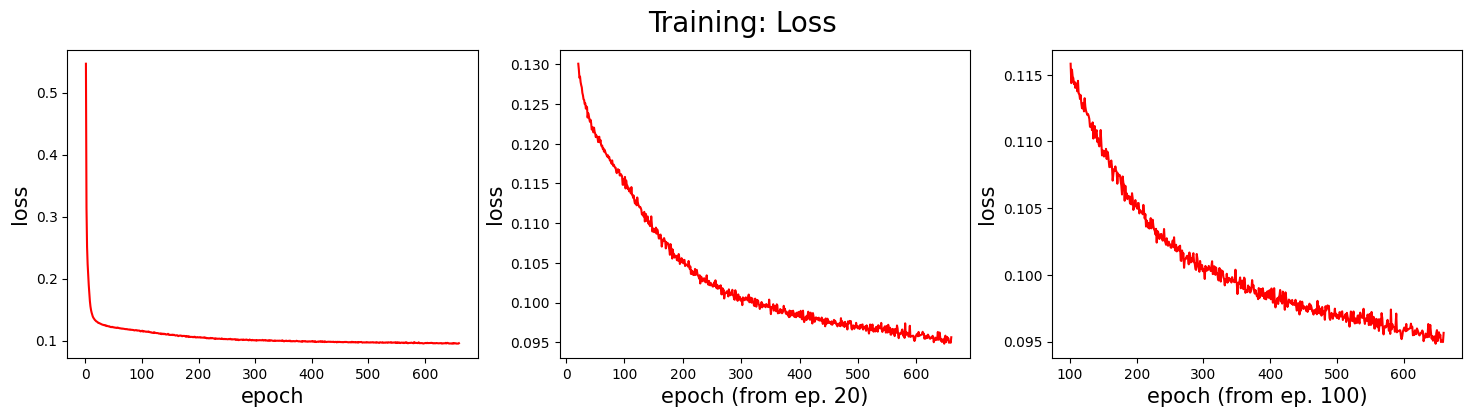

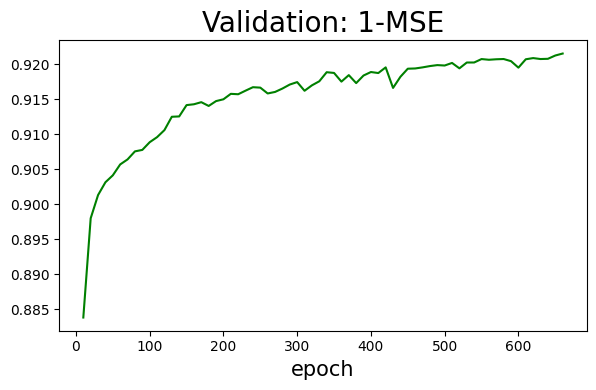

In [6]:
MULTI_TRAINING_FIGURE = True

if not MULTI_TRAINING_FIGURE:
    plt.figure("train", (6, 4))
    x = [i + 1 for i in range(len(epoch_loss_values))]
    y = epoch_loss_values
    plt.xlabel("epoch")
    plt.ylabel("loss - log")
    plt.yscale('log')
    plt.plot(x, y, color="red")
    plt.title("Training: Gaussian Log Likelihood Loss", fontsize=25)
    plt.savefig(os.path.join(fig_save_dir, "train_plot.png"), facecolor='white')
    plt.show()
else:
    plt.figure("train", (18, 4))
    plt.subplot(1, 3, 1)
    x = [i + 1 for i in range(len(epoch_loss_values))]
    y = epoch_loss_values
    plt.xlabel("epoch", fontsize=15)
    plt.ylabel("loss", fontsize=15)
    # plt.ylabel("loss - log", fontsize=15)
    # plt.yscale('log')
    plt.plot(x, y, color="red")
    plt.suptitle("Training: Loss", fontsize=20)

    k = 2
    for zoom in [20, 100]:
        if len(x) > zoom:
            plt.subplot(1, 3, k)
            x = [i + 1 for i in range(len(epoch_loss_values))]
            y = epoch_loss_values
            plt.ylabel("loss", fontsize=15)
            plt.xlabel(f"epoch (from ep. {zoom})", fontsize=15)
            
            plt.plot(x[zoom:], y[zoom:], color="red")
        k += 1
    plt.savefig(os.path.join(fig_save_dir, "train_plot.png"), facecolor='white')
    plt.show()

plt.figure("val", (6, 4))
plt.title("Validation: 1-MSE", fontsize=20)
x_val = [val_interval * (i + 1) for i in range(len(metric_values))]
y_val = metric_values
plt.xlabel("epoch", fontsize=15)
plt.tight_layout()
plt.plot(x_val, y_val, color="green")
plt.savefig(os.path.join(fig_save_dir, "val_plot.png"), facecolor='white')
# plt.ylim([0, 1])
plt.show()

## Inference on the model

In [7]:
import torch

from utils.model import create_UNet3D, inference
from utils.transforms import contr_syn_transform_2 as data_transform
from utils.dataset import BraTSDataset

In [8]:
input_filter = []
if INPUT_MODALITY == "ONLY_T1":
    input_filter = [1]
elif INPUT_MODALITY == "T1_T2":
    input_filter = [1,3]
elif INPUT_MODALITY == "T1_T2_FLAIR":
    input_filter = [0,1,3]

In [9]:
device = torch.device("cuda:0")
out_channels = 1
model = create_UNet3D(len(input_filter), out_channels, device)

In [10]:
val_dataset = BraTSDataset(
    version='2017',
    section = 'validation',
    seed = RANDOM_SEED,
    transform = data_transform['val']
)

In [12]:
checkpoint = torch.load(os.path.join(load_dir, 'best_checkpoint.pth'), weights_only=True)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
channels = ["FLAIR", "T1w", "T1Gd", "T2w"]
label_list = ["TC", "WT", "ET"]
input_mask = [False, False, True, False]
input_mask = np.array(input_mask)

# interesting ids with tummor: 328, 448

id_ = 429
with torch.no_grad():
    # this_input = val_dataset.get_random()
    this_input = val_dataset.get_with_id(id_)
    # input_image = this_input["image"].unsqueeze(0).to(device)
    # input_image_copy = input_image.clone()
    # input_image_copy[:, input_filter, ...] = 0
    # this_output = inference(input_image_copy, model)


    this_input_image = this_input["image"].to(device)
    this_groundtruth = this_input_image.clone()[:, [2], ...] # T1Gd
    this_input_image = this_input_image[:,input_filter, ...]
    this_output = inference(this_input_image, model)

ValueError: Sequence must have length 2, got 3.

In [79]:
from utils.plot import BrainPlot

In [80]:
plt.figure("image", (18, 18))
b_plot = BrainPlot(input_image, this_output, input_mask, h_index=77, id=id_)
for i in range(4):
    b_plot.plot("input")
for i in range(4):
    b_plot.plot("q0")
for i in range(4):
    b_plot.plot("q1")
for i in range(4):
    b_plot.plot("q2")
plt.savefig(os.path.join(fig_save_dir_root, "results", f"brats_{id_}.png"), facecolor='white')

### Evaluation metrics

In [81]:
from monai.data import DataLoader
import torch.nn.functional as torch_F
from torchmetrics.functional import structural_similarity_index_measure

def compute_ssim(predicted, ground):
    return structural_similarity_index_measure(predicted, ground, data_range=ground.max() - ground.min()).item()

def filter_with_mask(data, mask):
    return data[:, mask, ...]


In [82]:
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=4)
print(len(val_dataset.get_ids()))

97


In [83]:
def evaluate_metric(is_masked):
    ssim_list = []
    psnr_list = []

    model.eval()
    i = 0
    with torch.no_grad():
        for this_input in val_loader:
            i+=1
            if i > 10: break
            this_input_image = this_input["image"].to(device)
            this_groundtruth = this_input_image.clone()[:, [2], ...] # T1Gd
            this_input_image = this_input_image[:,input_filter, ...]
            this_predicted = inference(this_input_image, model)

            ssim_list.append(
                compute_ssim(this_predicted, this_groundtruth)
            )

            mse_loss_val = torch_F.mse_loss(this_predicted, this_groundtruth)
            peak_signal_value = torch.max(this_groundtruth) - torch.min(this_groundtruth)
            psnr_score = 20 * torch.log10(peak_signal_value / torch.sqrt(mse_loss_val))
            psnr_list.append(psnr_score.item())

    return np.mean(psnr_list), np.mean(ssim_list)

psnr_score, ssim_score = evaluate_metric(is_masked=None)
print("Overall score:")
print(f"PSNR: {psnr_score:.1f}")
print(f"SSIM: {ssim_score:.3f}")

Overall score:
PSNR: 35.3
SSIM: 0.909
